In [1]:
#transformers
#para instalar transformers: pip install transformers
%pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:

import torch
from torch import nn
from torch.nn import functional as F


In [3]:
#para hacer el stack de encoders
torch.nn.TransformerEncoder(encoder_layer, num_layers, norm=None)

NameError: name 'encoder_layer' is not defined

Un tranformer encoder es tener varios encoders seguidos

In [4]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        #esto sería el encoder
        self.embedding = nn.Embedding(ntoken, d_model)
        # me dice el tamaño de los embeddings
        self.d_model = d_model
        #esto sería el decoder
        self.linear = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    #la forward function me dice las operacioens de la red
    #la mascara es para que no se vean los tokens futuros, que solo mire los tokens anteriores
    def forward(self, src: Tensor, src_mask: Tensor = None) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        if src_mask is None:
            """Generate a square causal mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
            """
            src_mask = nn.Transformer.generate_square_subsequent_mask(len(src)).to(device)
        output = self.transformer_encoder(src, src_mask)
        output = self.linear(output)
        return output
    
    #esta funcion es para generar la mascara
    def generate_square_subsequent_mask(sz: int) -> Tensor:
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [5]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        #normaliza la posición del embedding
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

#esta función toma el input y le suma la posición del embedding
    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

## Load and batch data

In [6]:
%%bash
pip install portalocker
pip install torchdata

Given a 1-D vector of sequential data, batchify() arranges the data into batch_size columns. If the data does not divide evenly into batch_size columns, then the data is trimmed to fit. For instance, with the alphabet as the data (total length of 26) and batch_size=4, we would divide the alphabet into sequences of length 6, resulting in 4 of such sequences.

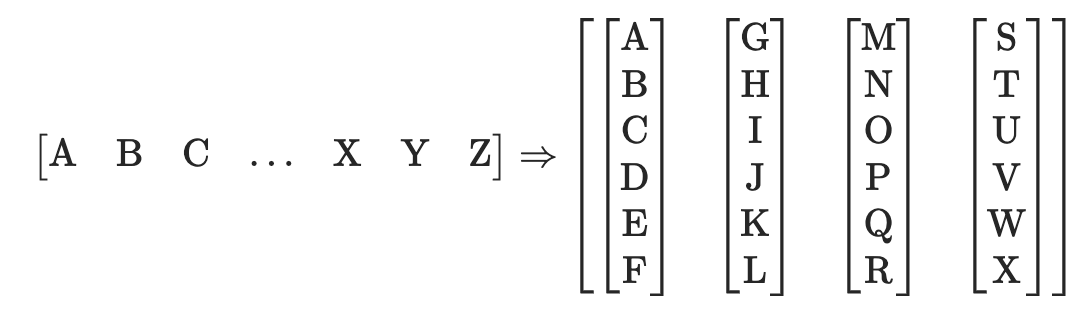

Batching enables more parallelizable processing. However, batching means that the model treats each column independently; for example, the dependence of G and F can not be learned in the example above.

In [8]:
#modifica este código para la ultima version de pytorch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# ``train_iter`` was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into ``bsz`` separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Arguments:
        data: Tensor, shape ``[N]``
        bsz: int, batch size

    Returns:
        Tensor of shape ``[N // bsz, bsz]``
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

# divido mi data en 20 partes
batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape ``[seq_len, batch_size]``
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

ImportError: cannot import name 'DILL_AVAILABLE' from 'torch.utils.data.datapipes.utils.common' (/Users/sofiatorres/anaconda3/lib/python3.10/site-packages/torch/utils/data/datapipes/utils/common.py)

In [ ]:
train_data.shape

Divide nuestra data entre input y target y crea batches para entrenar la red

Si quiero dividir mi data en bptt, quede decir que por ejemplo si tengo un bptt de 2, el primer batch va a coger solo dos elementos del input, en este caso AB y el target en la letra que le seguiría a cada letra del batch, por eso A->B y B->C

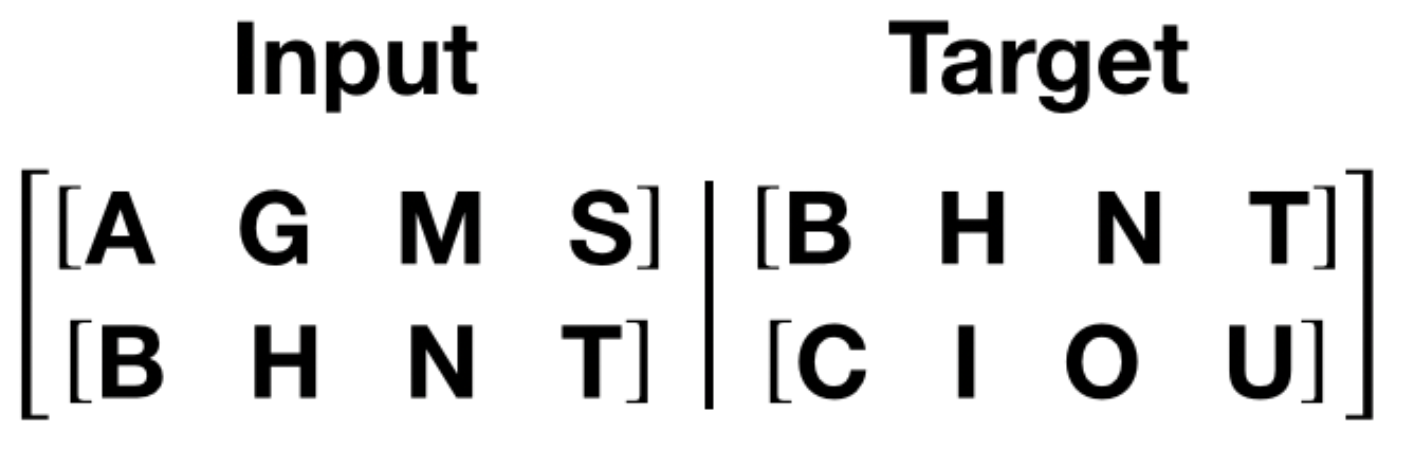

En este ejemplo la longitud de la secuencia sería 2 y el número de batchs sería 4

In [ ]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape ``[full_seq_len, batch_size]``
        i: int

    Returns:
        tuple (data, target), where data has shape ``[seq_len, batch_size]`` and
        target has shape ``[seq_len * batch_size]``
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

## Training loop

In [ ]:
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()

    num_batches = len(train_data) // bptt
    # hago un loop sobre mis datos, en lo chunk bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        output = model(data)
        output_flat = output.view(-1, ntokens)
        #computa todo el loss de la secuencia bptt
        loss = criterion(output_flat, targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            output = model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

### Cómo debería ser evaluado?

In [ ]:
best_val_loss = float('inf')
epochs = 3

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(model)
        val_loss = evaluate(model, val_data)
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_params_path)

        scheduler.step()
    model.load_state_dict(torch.load(best_model_params_path)) # load best model states

### Evaluar el mejor modelo

In [ ]:
test_loss = evaluate(model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)